In [1]:
import sys
sys.path.append('..')
from dnn import DNN
from dbn import DBN
from load_data import *

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm
import pickle
import os

# Load data

In [2]:
binary_alpha = lire_alpha_digits(['A', 'E', 'X', '4'])

In [3]:
X_train, y_train, X_test, y_test = load_mnist()

# Hyperparameters

In [4]:
epochs = 1000
batch_size = 512
learning_rate = 1e-3
patience = 10

nb_layers = 3
neurons = [512, 256, 256]

# Alpha Digits

In [16]:
dbn_alpha = DBN(X=binary_alpha, L=nb_layers, qs=neurons)

In [ ]:
dbn_alpha.train_DBN(epochs=epochs, learning_rate=learning_rate, batch_size=batch_size)

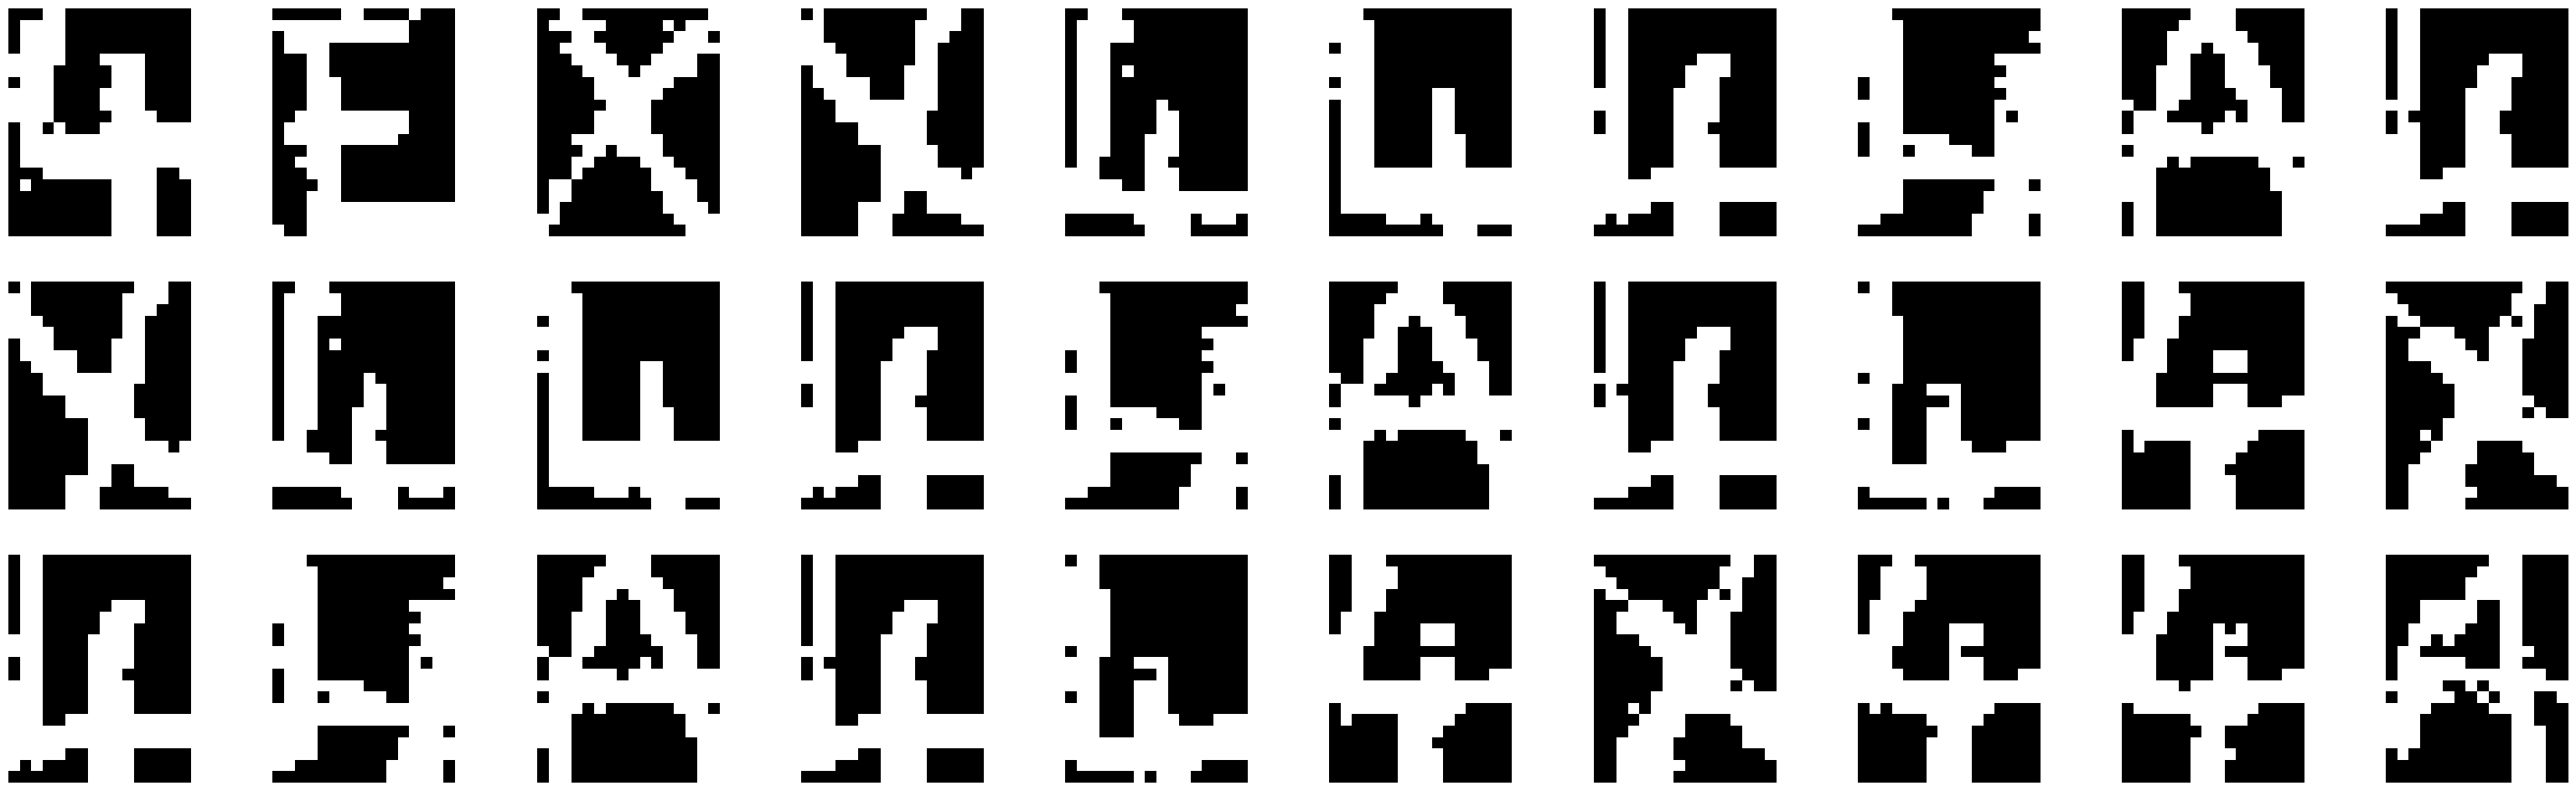

In [18]:
alpha_gen = dbn_alpha.generer_image_DBN(num_samples=30, gibbs_steps=2000, image_size=(20, 16))

# MNIST

In [5]:
def run_dnn(pretrain, nb_layers, neurons, suptitle, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, 
            epochs=epochs, learning_rate=learning_rate, batch_size=batch_size, plot_=True):
    dnn = DNN(X_train, y_train, num_classes=10, num_hidden_layers=nb_layers, neurons=neurons,
                X_val=X_test, y_val=y_test)
    if pretrain:
        dnn.pretrain_DNN(epochs=epochs, learning_rate=learning_rate, batch_size=batch_size)
    losses, accuracies, val_losses, val_accuracies = dnn.retropropagation(
    epochs=epochs, learning_rate=learning_rate, batch_size=batch_size, plot_=plot_, patience=patience, 
    suptitle=suptitle)
    return dnn, losses, accuracies, val_losses, val_accuracies

In [6]:
def save_list(l, path):
    with open(path, "wb") as fp: 
        pickle.dump(l, fp)
        
def open_list(path):
    with open(path, "rb") as fp:   
        l = pickle.load(fp)
    return l

In [7]:
def create_dirs(digit_figure):
    if not os.path.exists(f'figure{digit_figure}'):
        os.mkdir(f'figure{digit_figure}')
    if not os.path.exists(f'figure{digit_figure}/dnns'):
        os.mkdir(f'figure{digit_figure}/dnns')
    if not os.path.exists(f'.figure{digit_figure}/losses'):
        os.mkdir(f'figure{digit_figure}/losses')

In [8]:
def plot(i, losses_nb_layers, accuracies_nb_layers, val_losses_nb_layers, val_accuracies_nb_layers, ax, xlabel):
    ax[0].plot(losses_nb_layers[i][0], label='Train set- random init')
    ax[0].plot(losses_nb_layers[i][1], '--', label='Train set - pretrain')
    ax[0].plot(val_losses_nb_layers[i][0], label='Valid set- random init')
    ax[0].plot(val_losses_nb_layers[i][1], '--', label='Valid set - pretrain')
    ax[0].set_xlabel(xlabel)
    ax[0].grid('on')
    ax[0].legend()
    
    ax[1].plot(accuracies_nb_layers[i][0], label='Train set- random init')
    ax[1].plot(accuracies_nb_layers[i][1], '--', label='Train set - pretrain')
    ax[1].plot(val_accuracies_nb_layers[i][0], label='Valid set- random init')
    ax[1].plot(val_accuracies_nb_layers[i][1], '--', label='Valid set - pretrain')
    ax[1].grid('on')
    ax[1].legend()
    
    if i == 0:
        ax[0].set_title('Loss')
        ax[1].set_title('Accuracy')

In [11]:
def run_and_save(digit_figure, name, nb_layers, neurons, suptitle,
                 X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, epochs=epochs, learning_rate=learning_rate, batch_size=batch_size, plot_=True):
    if not os.path.exists(f'figure{digit_figure}/dnns/dnn_{name}.pkl'):
        dnn, losses, accuracies, val_losses, val_accuracies = run_dnn(False, nb_layers, neurons, suptitle=suptitle + ' - random init', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, 
                epochs=epochs, learning_rate=learning_rate, batch_size=batch_size, plot_=plot_)
        clear_output(wait=True)
        dnn.save_weights(f'figure{digit_figure}/dnns/dnn_{name}.pkl')
        save_list(losses, f'figure{digit_figure}/losses/losses_{name}.pkl')
        save_list(accuracies, f'figure{digit_figure}/losses/accuracies_{name}.pkl')
        save_list(val_losses, f'figure{digit_figure}/losses/val_losses_{name}.pkl')
        save_list(val_accuracies, f'figure{digit_figure}/losses/val_accuracies_{name}.pkl')

    print('pretrain -', name)
    if not os.path.exists(f'figure{digit_figure}/dnns/pretrain_dnn_{name}.pkl'):
        dnn, losses_pretrain, accuracies_pretrain, val_losses_pretrain, val_accuracies_pretrain = run_dnn(True, nb_layers, neurons, suptitle=suptitle + '- pretrain', X_train=X_train, y_train=y_train, 
                    X_test=X_test, y_test=y_test, epochs=epochs, learning_rate=learning_rate, batch_size=batch_size, plot_=plot_)
        clear_output(wait=True)
        dnn.save_weights(f'figure{digit_figure}/dnns/pretrain_dnn_{name}.pkl')
        save_list(losses_pretrain, f'figure{digit_figure}/losses/pretrain_losses_{name}.pkl')
        save_list(accuracies_pretrain, f'figure{digit_figure}/losses/pretrain_accuracies_{name}.pkl')
        save_list(val_losses_pretrain, f'figure{digit_figure}/losses/pretrain_val_losses_{name}.pkl')
        save_list(val_accuracies_pretrain, f'figure{digit_figure}/losses/pretrain_val_accuracies_{name}.pkl')

### Figure 1

In [12]:
layers = [2, 3, 5, 7, 10]
try:
    create_dirs(1)
except:
    pass

In [13]:
for nb_layer in layers:
    print(f'Nb layer: {nb_layer}')
    neurons = [200]*nb_layer
    run_and_save(1, nb_layer, nb_layer, neurons, suptitle=f'{nb_layers} layers',
                 X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, epochs=epochs, learning_rate=learning_rate, batch_size=batch_size, plot_=True)

pretrain - 10


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0: error = 0.1295
Epoch 20: error = 0.0443
Epoch 40: error = 0.0391
Epoch 60: error = 0.037
Epoch 80: error = 0.0356
Epoch 100: error = 0.0345
Epoch 120: error = 0.0338
Epoch 140: error = 0.0332
Epoch 160: error = 0.0327
Epoch 180: error = 0.0323
Epoch 200: error = 0.032
Epoch 220: error = 0.0316
Epoch 240: error = 0.0314
Epoch 260: error = 0.0312
Epoch 280: error = 0.031
Epoch 300: error = 0.0309
Epoch 320: error = 0.0307
Epoch 340: error = 0.0306
Epoch 360: error = 0.0305
Epoch 380: error = 0.0304
Epoch 400: error = 0.0303
Epoch 420: error = 0.0302
Epoch 440: error = 0.0301
Epoch 460: error = 0.03
Epoch 480: error = 0.0299
Epoch 500: error = 0.0298
Epoch 520: error = 0.0298
Epoch 540: error = 0.0297
Epoch 560: error = 0.0297
Epoch 580: error = 0.0296
Epoch 600: error = 0.0296
Epoch 620: error = 0.0295
Epoch 640: error = 0.0294
Epoch 660: error = 0.0294
Epoch 680: error = 0.0293
Epoch 700: error = 0.0293
Epoch 720: error = 0.0293
Epoch 740: error = 0.0292
Epoch 760: error = 0.02

 10%|█         | 1/10 [1:34:00<14:06:02, 5640.30s/it]

Epoch 0: error = 0.2924
Epoch 20: error = 0.127
Epoch 40: error = 0.1128
Epoch 60: error = 0.1057
Epoch 80: error = 0.1019
Epoch 100: error = 0.0994
Epoch 120: error = 0.0978
Epoch 140: error = 0.0965
Epoch 160: error = 0.0957
Epoch 180: error = 0.0949
Epoch 200: error = 0.0943
Epoch 220: error = 0.0939
Epoch 240: error = 0.0933
Epoch 260: error = 0.0929
Epoch 280: error = 0.0926
Epoch 300: error = 0.0922
Epoch 320: error = 0.0918
Epoch 340: error = 0.0914
Epoch 360: error = 0.0911
Epoch 380: error = 0.0909
Epoch 400: error = 0.0905
Epoch 420: error = 0.0903
Epoch 440: error = 0.09
Epoch 460: error = 0.0898
Epoch 480: error = 0.0895
Epoch 500: error = 0.0895
Epoch 520: error = 0.0893
Epoch 540: error = 0.0893
Epoch 560: error = 0.089
Epoch 580: error = 0.0888
Epoch 600: error = 0.0886
Epoch 620: error = 0.0886
Epoch 640: error = 0.0884
Epoch 660: error = 0.0883
Epoch 680: error = 0.0881
Epoch 700: error = 0.0881
Epoch 720: error = 0.0881
Epoch 740: error = 0.088
Epoch 760: error = 0.08

 20%|██        | 2/10 [1:58:40<7:05:44, 3193.03s/it] 

Epoch 0: error = 0.1466
Epoch 20: error = 0.0602
Epoch 40: error = 0.0561
Epoch 60: error = 0.0543
Epoch 80: error = 0.0533
Epoch 100: error = 0.0526
Epoch 120: error = 0.0524
Epoch 140: error = 0.0522
Epoch 160: error = 0.0518
Epoch 180: error = 0.0516
Epoch 200: error = 0.0516
Epoch 220: error = 0.0515
Epoch 240: error = 0.0512
Epoch 260: error = 0.0512
Epoch 280: error = 0.0512
Epoch 300: error = 0.051
Epoch 320: error = 0.051
Epoch 340: error = 0.0509
Epoch 360: error = 0.0509
Epoch 380: error = 0.0509
Epoch 400: error = 0.0507
Epoch 420: error = 0.0507
Epoch 440: error = 0.0507
Epoch 460: error = 0.0507
Epoch 480: error = 0.0506
Epoch 500: error = 0.0505
Epoch 520: error = 0.0505


In [ ]:
losses_nb_layers, accuracies_nb_layers, val_losses_nb_layers, val_accuracies_nb_layers = [], [], [], []
for nb_layer in layers:
    losses = open_list(f'figure1/losses/losses_{nb_layer}.pkl')
    accuracies = open_list(f'figure1/losses/accuracies_{nb_layer}.pkl')
    val_losses = open_list(f'figure1/losses/val_losses_{nb_layer}.pkl')
    val_accuracies = open_list(f'figure1/losses/val_accuracies_{nb_layer}.pkl')
    
    losses_pretrain = open_list(f'figure1/losses/pretrain_losses_{nb_layer}.pkl')
    accuracies_pretrain = open_list(f'figure1/losses/pretrain_accuracies_{nb_layer}.pkl')
    val_losses_pretrain = open_list(f'figure1/losses/pretrain_val_losses_{nb_layer}.pkl')
    val_accuracies_pretrain = open_list(f'figure1/losses/pretrain_val_accuracies_{nb_layer}.pkl')
    
    losses_nb_layers.append((losses, losses_pretrain))
    accuracies_nb_layers.append((accuracies, accuracies_pretrain))
    val_losses_nb_layers.append((val_losses, val_losses_pretrain))
    val_accuracies_nb_layers.append((val_accuracies, val_accuracies_pretrain))

In [ ]:
fig, axs = plt.subplots(len(layers), 2, figsize=(10, 4*len(layers)))
for i in range(len(layers)):
    plot(i, losses_nb_layers, accuracies_nb_layers, val_losses_nb_layers, val_accuracies_nb_layers, ax=axs[i], 
         xlabel=f'{layers[i]} layers')

### Figure 2

In [ ]:
nb_neurons = [100, 200, 700, 1000]
try:
    create_dirs(2)
except:
    pass

In [ ]:
for nb_neuron in nb_neurons:
    neurons = [nb_neuron]*2
    print(f'Nb neurons: {nb_neuron}')
    run_and_save(2, nb_neuron, 2, neurons, suptitle=f'{nb_neuron} neurons',
                 X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, epochs=epochs, learning_rate=learning_rate, batch_size=batch_size, plot_=True)

In [ ]:
losses_nb_neurons, accuracies_nb_neurons, val_losses_nb_neurons, val_accuracies_nb_neurons = [], [], [], []
for nb_neuron in nb_neurons:
    losses = open_list(f'figure2/losses/losses_{nb_neuron}.pkl')
    accuracies = open_list(f'figure2/losses/accuracies_{nb_neuron}.pkl')
    val_losses = open_list(f'figure2/losses/val_losses_{nb_neuron}.pkl')
    val_accuracies = open_list(f'figure2/losses/val_accuracies_{nb_neuron}.pkl')
    
    losses_pretrain = open_list(f'figure2/losses/pretrain_losses_{nb_neuron}.pkl')
    accuracies_pretrain = open_list(f'figure2/losses/pretrain_accuracies_{nb_neuron}.pkl')
    val_losses_pretrain = open_list(f'figure2/losses/pretrain_val_losses_{nb_neuron}.pkl')
    val_accuracies_pretrain = open_list(f'figure2/losses/pretrain_val_accuracies_{nb_neuron}.pkl')
    
    losses_nb_neurons.append((losses, losses_pretrain))
    accuracies_nb_neurons.append((accuracies, accuracies_pretrain))
    val_losses_nb_neurons.append((val_losses, val_losses_pretrain))
    val_accuracies_nb_neurons.append((val_accuracies, val_accuracies_pretrain))

In [ ]:
fig, axs = plt.subplots(len(nb_neurons), 2, figsize=(10, 4*len(nb_neurons)))
for i in range(len(nb_neurons)):
    plot(i, losses_nb_neurons, accuracies_nb_neurons, val_losses_nb_neurons, val_accuracies_nb_neurons, ax=axs[i], 
         xlabel=f'{nb_neurons[i]} neurons')

### Figure 3

In [ ]:
lenTrains = [1000, 3000, 7000, 10_000, 30_000, 60_000]
try:
    create_dirs(3)
except:
    pass

In [ ]:
for lenTrain in lenTrains:
    print(f'Length train: {lenTrain}')
    indices = np.random.choice(range(len(X_train)), size=lenTrain, replace=False)
    sub_X_train = X_train[indices]
    sub_y_train = y_train[indices]
    
    run_and_save(3, lenTrain, 2, [200, 200], suptitle=f'{lenTrain} training samples',
                 X_train=sub_X_train, y_train=sub_y_train, X_test=X_test, y_test=y_test, epochs=epochs, learning_rate=learning_rate, batch_size=batch_size, plot_=True)

In [ ]:
losses_nb_train, accuracies_nb_train, val_losses_nb_train, val_accuracies_nb_train = [], [], [], []
for lenTrain in lenTrains:
    losses = open_list(f'figure3/losses/losses_{lenTrain}.pkl')
    accuracies = open_list(f'figure3/losses/accuracies_{lenTrain}.pkl')
    val_losses = open_list(f'figure3/losses/val_losses_{lenTrain}.pkl')
    val_accuracies = open_list(f'figure3/losses/val_accuracies_{lenTrain}.pkl')
    
    losses_pretrain = open_list(f'figure3/losses/pretrain_losses_{lenTrain}.pkl')
    accuracies_pretrain = open_list(f'figure3/losses/pretrain_accuracies_{lenTrain}.pkl')
    val_losses_pretrain = open_list(f'figure3/losses/pretrain_val_losses_{lenTrain}.pkl')
    val_accuracies_pretrain = open_list(f'figure3/losses/pretrain_val_accuracies_{lenTrain}.pkl')
    
    losses_nb_train.append((losses, losses_pretrain))
    accuracies_nb_train.append((accuracies, accuracies_pretrain))
    val_losses_nb_train.append((val_losses, val_losses_pretrain))
    val_accuracies_nb_train.append((val_accuracies, val_accuracies_pretrain))

In [ ]:
fig, axs = plt.subplots(len(lenTrains), 2, figsize=(10, 4*len(lenTrains)))
for i in range(len(lenTrains)):
    plot(i, losses_nb_train, accuracies_nb_train, val_losses_nb_train, val_accuracies_nb_train, ax=axs[i], 
         xlabel=f'{lenTrains[i]} training samples')